<a href="https://colab.research.google.com/github/mjgroth/deephys-aio/blob/master/tutorials/Colored_MNIST_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Deephy



In [1]:
#@title 1. Install dependencies
!pip install torch torchvision # We will use Torch as the deep net platform
!pip install deephys==0.14.0 # To export the neural activity to deephys

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 KB 7.1 MB/s eta 0:00:00


# Run Neural Network Experiment

In [3]:
#@title 2. Define neural net model

#Import Libraries
from __future__ import print_function
import argparse
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import tqdm

# Neural network model definition

class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()  #Dropout
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #Convolutional Layer/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        #Convolutional Layer/Dropout/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        #Fully Connected Layer/Activation
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        #Fully Connected Layer/Activation
        x = self.fc2(x)
        #Softmax gets probabilities. 
        return F.log_softmax(x, dim=1)


In [4]:
#@title 3. Load the model. Define hooks to extract the neural activity from the network

args={}
args['batch_size'] = 1000
args['cuda'] = True # Enabling cuda is required

# Instntiate model
model = Net()
if args['cuda']:
    model.cuda()

#Load pre-trained model
state_dict = torch.load('checkpoint_c_mod.pth')
model.load_state_dict(state_dict)
model.eval() # testing model

# Hooks to extract the neural activity from the model
model_activity = {}
def get_activation(name):
  def hook(model, input, output):
    model_activity[name] = output.detach()
  return hook

# We will only pull from the fc1 layer
h = model.fc1.register_forward_hook(get_activation('linear1'))

In [5]:
#@title 4. Define function to extract data to export to deephys from the model
def extract_activity(testloader, model):

  # All we need for Deephys
  dp_images = []
  dp_gt = []
  dp_activity = {
      "output": [], 
      "linear1": []
  }
  
  # Loop across all dataset 
  for data, target in iter(testloader):

      dp_images.append(data)
      dp_gt.append(target)

      if args['cuda']:
        data, target = data.cuda(), target.cuda()
  
      with torch.no_grad():
        tmp_activity = model(data).detach().cpu()
        dp_activity['output'].append(tmp_activity)
        tmp_activity = F.relu(model_activity['linear1']).detach().cpu()
        dp_activity['linear1'].append(tmp_activity)

  # Convert torch tensors to numpy
  for layer in dp_activity:
        dp_activity[layer] = torch.cat(dp_activity[layer]).numpy()

  dp_images = torch.cat(dp_images).numpy()
  dp_gt = torch.cat(dp_gt).numpy()

  return dp_images, dp_gt, dp_activity

In [6]:
#@title 5. Deephys model

import deephys as dp

classes = ['0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9']

dp_model = dp.model(
    name = "colored_mnist",
    layers = {
        "linear1": model.fc1.out_features,
        "output": len(classes)
    },
    classification_layer="output"
)

dp_model.save()

Saving data to colored_mnist.model...
done saving data to colored_mnist.model


In [7]:
#@title 6. Generate colors for MNIST InD and OOD versions

def get_color_codes(opt_c):
    if opt_c == 1: #Original color transformation
      C = np.array([[ 0.13710051,  1.        ,  0.71222024],
         [ 1.        ,  0.23502843,  0.21756662],
         [ 1.        ,  0.38958   ,  0.08445272],
         [ 0.3963379 ,  0.59521337,  1.        ],
         [ 0.65700309,  0.70908503,  1.        ],
         [ 1.        ,  0.09696472,  0.50587124],
         [ 0.51142274,  0.91275694,  1.        ],
         [ 1.        ,  0.6304754 ,  0.09344255],
         [ 1.        ,  0.80362454,  0.51662567],
         [ 0.40087705,  0.79163833,  1.        ]])
      
    elif opt_c == 2: #Random permutation of the original colours
      C = np.array([[ 1.        ,  0.38958   ,  0.08445272],
        [ 1.        ,  0.09696472,  0.50587124],
        [ 0.3963379 ,  0.59521337,  1.        ],
        [ 0.13710051,  1.        ,  0.71222024],
        [ 0.40087705,  0.79163833,  1.        ],
        [ 1.        ,  0.80362454,  0.51662567],
        [ 1.        ,  0.6304754 ,  0.09344255],
        [ 0.65700309,  0.70908503,  1.        ],
        [ 0.51142274,  0.91275694,  1.        ],
        [ 1.        ,  0.23502843,  0.21756662]])
      
    elif opt_c == 3: #Arbitrary color transformation
      C = np.array([[ 1.        ,  0.41949873,  0.99060461],
          [ 0.45823549,  1.        ,  0.35099324],
          [ 0.18897236,  1.        ,  0.0655438 ],
          [ 0.61364824,  0.52432431,  1.        ],
          [ 0.20415346,  1.        ,  0.7115653 ],
          [ 0.18451955,  0.76054322,  1.        ],
          [ 0.67399901,  1.        ,  0.17729946],
          [ 0.58266085,  1.        ,  0.16336576],
          [ 1.        ,  0.7173036 ,  0.8670752 ],
          [ 0.86803908,  0.98159648,  1.        ]])
      
    elif opt_c == 4: #Create drifted colors by subtracting a fixed value
      C = np.array([[ 0.13710051,  1.        ,  0.71222024],
         [ 1.        ,  0.23502843,  0.21756662],
         [ 1.        ,  0.38958   ,  0.08445272],
         [ 0.3963379 ,  0.59521337,  1.        ],
         [ 0.65700309,  0.70908503,  1.        ],
         [ 1.        ,  0.09696472,  0.50587124],
         [ 0.51142274,  0.91275694,  1.        ],
         [ 1.        ,  0.6304754 ,  0.09344255],
         [ 1.        ,  0.80362454,  0.51662567],
         [ 0.40087705,  0.79163833,  1.        ]])
      random_ep = 0.2726747
      C = C - random_ep
      
    return C

def gen_color_data(loader, img_size=(3, 28, 28), opt_c=1):
    Cfg = get_color_codes(opt_c) #Get the set of colors

    tot_iters = len(loader)
    iters = iter(loader)
    for i in tqdm.tqdm(range(tot_iters), total=tot_iters):
      x, targets = next(iters)
      targets = targets.cpu().numpy()

      x = (((x * 255) > 150) * 255).type('torch.FloatTensor')
      x_rgb = torch.ones(x.size(0), 3, x.size()[2], x.size()[3]).type('torch.FloatTensor')
      x_rgb = x_rgb * x
      x_rgb_fg = 1. * x_rgb

      c = Cfg[targets] #Select colors according to the ground truth category
      c = c.reshape(-1, 3, 1, 1)
      c = torch.from_numpy(c).type('torch.FloatTensor')
      x_rgb_fg[:, 0] = x_rgb_fg[:, 0] * c[:, 0]
      x_rgb_fg[:, 1] = x_rgb_fg[:, 1] * c[:, 1]
      x_rgb_fg[:, 2] = x_rgb_fg[:, 2] * c[:, 2]

      x_rgb = torch.clamp(x_rgb_fg, 0., 255.)

      if i == 0:
        color_data_x = np.zeros((args['batch_size'] * len(loader), *img_size))
        color_data_y = np.zeros((args['batch_size'] * len(loader),))
      color_data_x[i * args['batch_size']: (i + 1) * args['batch_size']] = x_rgb / 255.
      color_data_y[i * args['batch_size']: (i + 1) * args['batch_size']] = targets

    return color_data_x, color_data_y

In [8]:
#@title 7. Download original MNIST dataset
mnist_test = datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_loader = torch.utils.data.DataLoader(mnist_test,
    batch_size=args['batch_size'], shuffle=False, num_workers=2)

In [9]:
#@title 8. Export data from Colored MNIST to Deephys

color_data_x, color_data_y = gen_color_data(test_loader, img_size=(3, 28, 28), opt_c=1) #opt_c = 1 for original InD set of colors

color_data_test = TensorDataset(torch.FloatTensor(color_data_x), torch.LongTensor(color_data_y))
color_test_loader = torch.utils.data.DataLoader(color_data_test,
    batch_size=args['batch_size'], shuffle=False, num_workers=2)

color_images, color_gt, color_activity = extract_activity(color_test_loader, model)


# To Deephys
dataset_activity = dp.dataset_activity(
    name = "Colored_MNIST",
    category_names = classes,
    images = color_images,
    groundtruth = color_gt,
    neural_activity = color_activity,
    model=dp_model,
    )
dataset_activity.save()
     

100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


Preparing data...


100%|██████████| 10000/10000 [00:03<00:00, 3288.09it/s]


Saving data to Colored_MNIST.test...
done saving data to Colored_MNIST.test


In [13]:
#@title 9. Export data from Permuted Colored MNIST to Deephys

color_data_x_perm, color_data_y_perm = gen_fgbgcolor_data(test_loader, img_size=(3, 28, 28), opt_c=2) #opt_c = 2 for permuted colors

color_data_test_perm = TensorDataset(torch.FloatTensor(color_data_x_perm), torch.LongTensor(color_data_y_perm))
color_test_loader_perm = torch.utils.data.DataLoader(color_data_test_perm,
    batch_size=args['batch_size'], shuffle=False, num_workers=2)

color_images_perm, color_gt_perm, color_activity_perm = extract_activity(color_test_loader_perm, model)


# To Deephys
dataset_activity = dp.dataset_activity(
    name = "Permuted_colored_MNIST",
    category_names = classes,
    images = color_images_perm,
    groundtruth = color_gt_perm,
    neural_activity = color_activity_perm,
    model=dp_model,
    )
dataset_activity.save()
     

100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


Preparing data...


100%|██████████| 10000/10000 [00:01<00:00, 5090.99it/s]


Saving data to Permuted_colored_MNIST.test...
done saving data to Permuted_colored_MNIST.test


In [14]:
#@title 10. Export data from Arbitrary Colored MNIST to Deephys

color_data_x_arb, color_data_y_arb = gen_fgbgcolor_data(test_loader, img_size=(3, 28, 28), opt_c=3) #opt_c = 3 for arbitrary colors

color_data_test_arb = TensorDataset(torch.FloatTensor(color_data_x_arb), torch.LongTensor(color_data_y_arb))
color_test_loader_arb = torch.utils.data.DataLoader(color_data_test_arb,
    batch_size=args['batch_size'], shuffle=False, num_workers=2)

color_images_arb, color_gt_arb, color_activity_arb = extract_activity(color_test_loader_arb, model)


# To Deephys
dataset_activity = dp.dataset_activity(
    name = "Arbitrary_colored_MNIST",
    category_names = classes,
    images = color_images_arb,
    groundtruth = color_gt_arb,
    neural_activity = color_activity_arb,
    model=dp_model,
    )
dataset_activity.save()

100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


Preparing data...


100%|██████████| 10000/10000 [00:01<00:00, 5288.88it/s]


Saving data to Arbitrary_colored_MNIST.test...
done saving data to Arbitrary_colored_MNIST.test


In [15]:
#@title 11. Export data from Drifted Colored MNIST to Deephys

color_data_x_drift, color_data_y_drift = gen_fgbgcolor_data(test_loader, img_size=(3, 28, 28), opt_c=4) #opt_c = 4 for drifted colors

color_data_test_drift = TensorDataset(torch.FloatTensor(color_data_x_drift), torch.LongTensor(color_data_y_drift))
color_test_loader_drift = torch.utils.data.DataLoader(color_data_test_drift,
    batch_size=args['batch_size'], shuffle=False, num_workers=2)

color_images_drift, color_gt_drift, color_activity_drift = extract_activity(color_test_loader_drift, model)


# To Deephys
dataset_activity = dp.dataset_activity(
    name = "Drifted_colored_MNIST",
    category_names = classes,
    images = color_images_drift,
    groundtruth = color_gt_drift,
    neural_activity = color_activity_drift,
    model=dp_model,
    )
dataset_activity.save()

100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


Preparing data...


100%|██████████| 10000/10000 [00:02<00:00, 3671.28it/s]


Saving data to Drifted_colored_MNIST.test...
done saving data to Drifted_colored_MNIST.test


#Novelty and Spurious Scores

In [16]:
#@title Normalize and get average firing rates per category

num_neurons = model.fc1.out_features
num_classes = len(classes)

norm = np.max(color_activity["linear1"], axis=0)
color_activity["linear1"] /= norm
color_activity_perm["linear1"] /= norm
color_activity_arb["linear1"] /= norm
color_activity_drift["linear1"] /= norm


# average scores for every concept across all images
Y = np.array([np.mean(color_activity["linear1"][np.where(color_gt == c)[0], :], axis=0) 
          for c in range(num_classes)]) #Colored MNIST

Y_perm = np.array([np.mean(color_activity_perm["linear1"][np.where(color_gt_perm == c)[0], :], axis=0) 
          for c in range(num_classes)]) #Permuted Colored MNIST

Y_arb = np.array([np.mean(color_activity_arb["linear1"][np.where(color_gt_arb == c)[0], :], axis=0) 
          for c in range(num_classes)]) #Arbitrary Colored MNIST

Y_drift = np.array([np.mean(color_activity_drift["linear1"][np.where(color_gt_drift == c)[0], :], axis=0) 
          for c in range(num_classes)]) #Drifted Colored MNIST

In [17]:
#@title Calculate Spurious and Novelty scores

from scipy.stats.mstats import spearmanr
import pandas as pd

def Spurious_Score(avg_acts_1, avg_acts_2):
    #Spearman's rank correlation calculation
    spearman_corr = [1-abs(spearmanr(avg_acts_1[:,i], avg_acts_2[:,i])[0])
          for i in range(len(avg_acts_1[0]))]
    
    return spearman_corr

def Novelty_Score(avg_acts_1, avg_acts_2):
  max_acts = np.max(avg_acts_1, axis=0)
  max_acts_2 = np.max(avg_acts_2, axis=0)

  diff_acts = list(max_acts - max_acts_2)
  return diff_acts


# Calculate and store in dataframe
spurious_perm = Spurious_Score(Y, Y_perm)
spurious_arb = Spurious_Score(Y, Y_arb)
spurious_drift = Spurious_Score(Y, Y_drift)

novelty_perm = Novelty_Score(Y, Y_perm)
novelty_arb = Novelty_Score(Y, Y_arb)
novelty_drift = Novelty_Score(Y, Y_drift)

df = pd.DataFrame({
  'Spurious_perm': spurious_perm,
  'Spurious_arb': spurious_arb,
  'Spurious_drift': spurious_drift,
  'Novelty_perm': novelty_perm,
  'Novelty_arb': novelty_arb,
  'Novelty_drift': novelty_drift
})

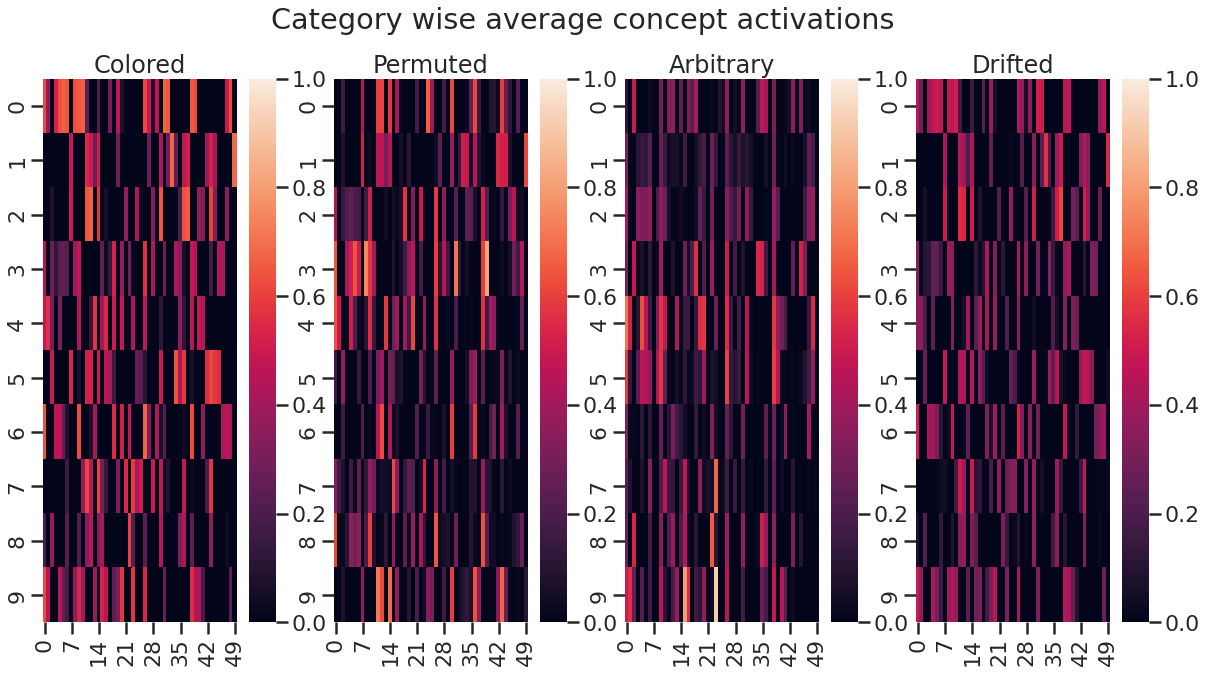

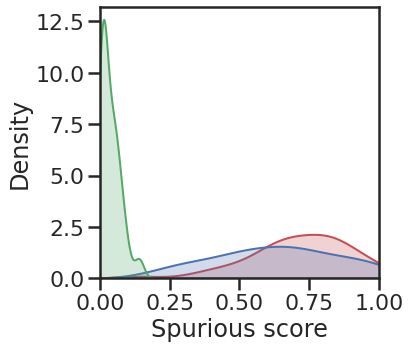

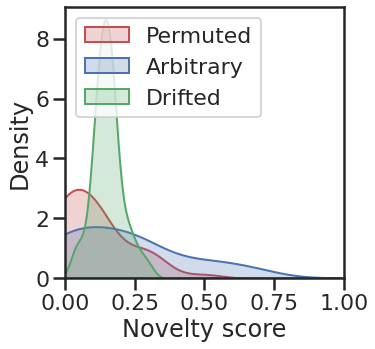

In [20]:
#@title Plot scores

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
sns.set_context("poster")


fig, axes = plt.subplots(1, 4, figsize = (20, 10))
fig.suptitle('Category wise average concept activations')
fig = sns.heatmap(Y, ax=axes[0], vmin=0, vmax=1)
fig = sns.heatmap(Y_perm, ax=axes[1], vmin=0, vmax=1)
fig = sns.heatmap(Y_arb, ax=axes[2], vmin=0, vmax=1)
fig = sns.heatmap(Y_drift, ax=axes[3], vmin=0, vmax=1)

axes[0].set_title('Colored')
axes[1].set_title('Permuted')
axes[2].set_title('Arbitrary')
axes[3].set_title('Drifted')


fig, axes = plt.subplots(1, 1, figsize = (5, 5))
fig = sns.kdeplot(df['Spurious_perm'], shade=True, color="r")
fig = sns.kdeplot(df['Spurious_arb'], shade=True, color="b")
fig = sns.kdeplot(df['Spurious_drift'], shade=True, color="g")
plt.xlim(0, 1)
axes.set_xlabel('Spurious score')

plt.show()
g = fig.figure
g.savefig("MNIST_spurious.pdf", bbox_inches='tight')

fig, axes = plt.subplots(1, 1, figsize = (5, 5))
fig = sns.kdeplot(df['Novelty_perm'], shade=True, color="r")
fig = sns.kdeplot(df['Novelty_arb'], shade=True, color="b")
fig = sns.kdeplot(df['Novelty_drift'], shade=True, color="g")
plt.xlim(0, 1)
plt.gca().legend(('Permuted','Arbitrary', 'Drifted'), loc ="upper left")
axes.set_xlabel('Novelty score')

plt.show()
g = fig.figure
g.savefig("MNIST_novelty.pdf", bbox_inches='tight')